<a href="https://colab.research.google.com/github/Cipe96/EEG-Recognition/blob/main/Classificatore_Convolutivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>**EEG Recognition: Classificatore Convolutivo**</font>
</br><font size=3>*Marco Cipollina, Riccardo Era*</font>


<p style="font-size:4px;" align="justify">Dopo aver svolto vari tipi di analisi sul nostro dataset e considerate le varie possibilità di preprocessing attuabile in "Analisi Dataset e Preprocessing", in questo notebook viene costruito e addestrato un modello Convolutivo (CCN) semplice. Questo classificatore sarà utilizzato come baseline per ricercare la migliore combinazione di preprocessing da sfruttare succesivamente in un modello più complesso.</p>
<p style="font-size:4px;" align="justify">Qui sotto è perciò possibile caricare e lavorare su un determinato dataset e salvarne i risultati. I dati da noi ottenuti saranno confrontati ed esposti nel noteobok "Risultati".</p>

<font size=4>**Indice:**</font>
*   [Import librerie](#1)
*   [Downloads](#2)
*   [Classificatore](#3)

<a name="1"></a>
# **Import librerie**

Importiamo le librerie e montiamo Google Drive per garantire l'accesso agli altri file.

In [1]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import os

SEED = 96                                                                       #Impostiamo un seme specifico per garantire la replicabilità degli esperimenti

In [2]:
%%capture
drive.mount('/content/drive', force_remount=True)

# elimina la cartella sample_data creata automaticamente
! rm -r /content/sample_data

In [3]:
#@title Percorso della cartella del progetto su Google Drive:

#@markdown Se la cartella del progetto si trova nella root di Drive, scrivere solo il suo nome:

PERCORSO_DRIVE = "EEG Recognition" #@param {type:"string"}

PERCORSO_DRIVE = '/content/drive/MyDrive/' + PERCORSO_DRIVE

In [4]:
sys.path.append(PERCORSO_DRIVE)                                                 # ci permetterà di importare le funzioni presenti in altri file
from shared_utilities import convolutivo                                        # importare il classificatore convolutivo

<a name="2"></a>
# **Download**

In [82]:
#@title Seleziona la Run che vuoi utilizzare (fra quelle che hai sul drive):

#@markdown Inserisci un valore compreso fra 1 e 14 inclusi:

run = 6 #@param {type:"integer"}
run = f"R{run:02d}"


In [83]:
#@title Seleziona la banda che vuoi utilizzare:

#@markdown (delta, theta, alpha, beta, gamma, broadband, personalizzata, ABG)

banda = 'ABG' #@param ['delta', 'theta', 'alpha', 'beta', 'gamma', 'broadband', 'personalizzata', 'ABG']
save_path = f'{PERCORSO_DRIVE}/Dati preprocessati/{run}/{banda}'

In [84]:
#@title Carica i dati
train_data = np.load(f"{save_path}/train_data_{banda}.npy")
train_labels = np.load(f"{save_path}/train_labels_{banda}.npy")
val_data = np.load(f"{save_path}/val_data_{banda}.npy")
val_labels = np.load(f"{save_path}/val_labels_{banda}.npy")
test_data = np.load(f"{save_path}/test_data_{banda}.npy")
test_labels = np.load(f"{save_path}/test_labels_{banda}.npy")

Controlliamo che la shape sia coerente con quella che ci servirà per il modello di classificazione

In [85]:
# Verifica le dimensioni dei dataset e delle etichette
print(f"Train set shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation set shape: {val_data.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test set shape: {test_data.shape}, Test labels shape: {test_labels.shape}")

Train set shape: (6235, 240, 64), Train labels shape: (6235,)
Validation set shape: (1308, 240, 64), Validation labels shape: (1308,)
Test set shape: (1417, 240, 64), Test labels shape: (1417,)


Effettuiamo uno shuffle del dataset per evitare di dare in pasto i dati al modello in maniera ordinata, permettendo così un addestramento meno condizionato.

In [86]:
# shuffle dei dataset e ettichette con stesso ordine di shuffle
train_data, train_labels = shuffle(train_data, train_labels, random_state=SEED)
val_data, val_labels = shuffle(val_data, val_labels, random_state=SEED)
test_data, test_labels = shuffle(test_data, test_labels, random_state=SEED)


In [87]:
# Riprendiamo il numero di classi esistenti
num_classes = len(np.unique(train_labels))
print("Numero di classi:", num_classes)

# Convertiamo le etichette in one-hot encoding
y_train = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)


Numero di classi: 109


<a name="3"></a>
# **Classificatore**

Costruiamo il nostro modello convoluzionale utilizzando alcune delle best practices (SeparableConv, DropOut, BatchNormalization) e uno strato Dense per permetterci di classificare i nostri volontari.

In [99]:
# Preleviamo la shape da dare in input al modello
shape=(train_data.shape[1], train_data.shape[2])

# Impostiamo i parametri per i blocchi convolutivi
filtri = 64
strati = 1
dropout = 0.15
primo_sep = False

model = convolutivo(num_classes, shape, filtri, dropout, strati, primo_sep)

# Compiliamo il modello
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Verifichiamo che il modello sia costruito come vogliamo.

In [100]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 240, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 240, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 240, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 240, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_9           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 109)                 │           7,085 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,693 (76.93 KB)

 Trainable params: 19,565 (76.43 KB)

 Non-trainable params: 128 (512.00 B)

Creiamo una callback per salvare i pesi con i quali si otterranno i risultati migliori sul validation set e avviamo il training.

In [101]:
#@title Addestramento con validazione
#Salviamo i pesi dell'epoca in cui abbiamo ottenuto il val_loss minore
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f"best-{banda}-conv.keras", save_best_only=True, monitor="val_loss"),
]

# Addestriamo il modello
history = model.fit(train_data, y_train, epochs=50, batch_size=32, validation_data=(val_data, y_val), callbacks=callback)


Epoch 1/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.0776 - loss: 4.4058 - val_accuracy: 0.2615 - val_loss: 3.8606
Epoch 2/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3273 - loss: 3.5891 - val_accuracy: 0.4465 - val_loss: 3.1631
Epoch 3/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5163 - loss: 2.9685 - val_accuracy: 0.6613 - val_loss: 2.5025
Epoch 4/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6821 - loss: 2.3616 - val_accuracy: 0.7546 - val_loss: 1.9563
Epoch 5/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7656 - loss: 1.8464 - val_accuracy: 0.8180 - val_loss: 1.5142
Epoch 6/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8165 - loss: 1.4411 - val_accuracy: 0.8502 - val_loss: 1.2187
Epoch 7/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8500 - loss: 1.1528 - val_accuracy: 0.8731 - val_loss: 0.9707
Epoch 8/50
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8688 - loss: 0.9372 - val_accuracy: 0

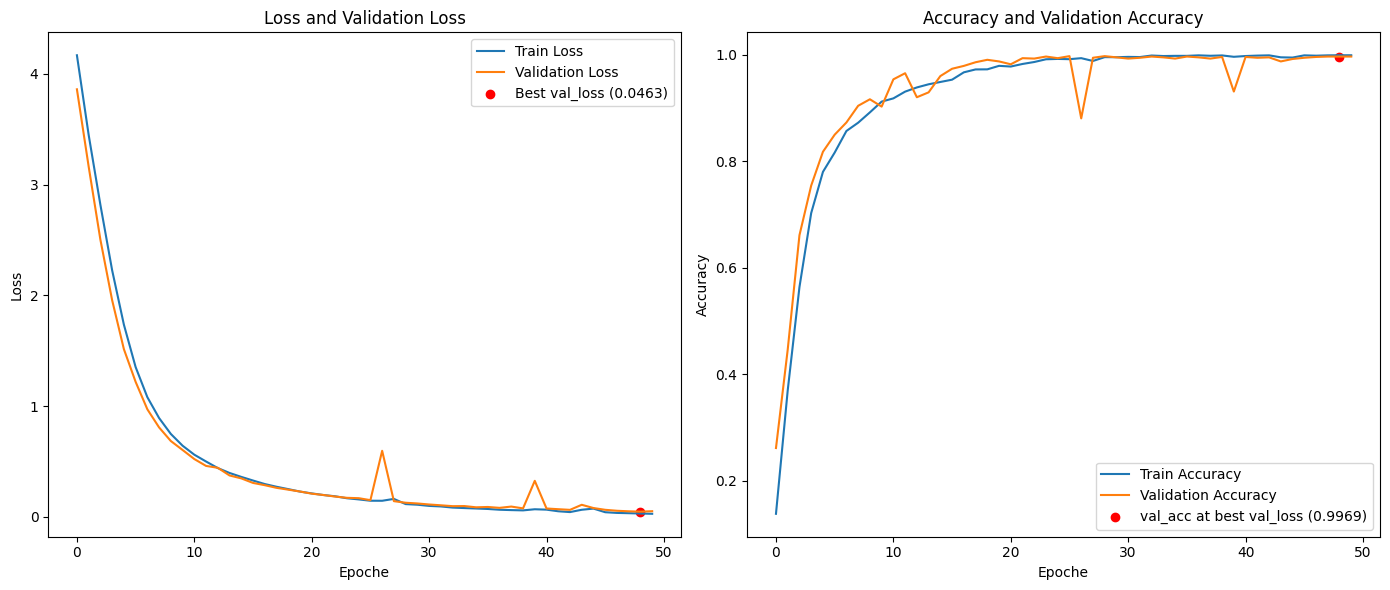

In [102]:
#@title Grafico confroto fra Loss e Accuratezze
# Estrarre i dati dall'oggetto `history`
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', [])  # Alcuni modelli usano 'acc' invece di 'accuracy'
val_accuracy = history.history.get('val_accuracy', [])

# Individuare l'epoca con la miglior val_loss
best_epoch = np.argmin(val_loss)
best_val_loss = val_loss[best_epoch]

# Creare i grafici
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Un grafico accanto all'altro

# Grafico Loss
axes[0].plot(loss, label="Train Loss")
axes[0].plot(val_loss, label="Validation Loss")
axes[0].scatter(best_epoch, best_val_loss, color='red', label=f"Best val_loss ({best_val_loss:.4f})")
axes[0].set_title("Loss and Validation Loss")
axes[0].set_xlabel("Epoche")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Grafico Accuracy
if accuracy and val_accuracy:
    axes[1].plot(accuracy, label="Train Accuracy")
    axes[1].plot(val_accuracy, label="Validation Accuracy")
    if val_accuracy:
        best_val_accuracy = val_accuracy[best_epoch]
        axes[1].scatter(best_epoch, best_val_accuracy, color='red', label=f"val_acc at best val_loss ({best_val_accuracy:.4f})")
    axes[1].set_title("Accuracy and Validation Accuracy")
    axes[1].set_xlabel("Epoche")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

# Mostrare i grafici
plt.tight_layout()
plt.show()


---
Una volta convalidati gli iperparametri grazia al
validation set, sfruttiamo tutti i dati disponibili per l'addestramento del modello.

In [94]:
#@title Uniamo e rimescoliamo trainset con validation set

# Uniamo i dati
combined_data = np.concatenate((train_data, val_data), axis=0)
combined_labels = np.concatenate((y_train, y_val), axis=0)

# Mescoliamo di nuovo
combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=SEED)

In [105]:
#@title Addestramento finale
#Ricompiliamo il modello
model = convolutivo(num_classes, shape, filtri, dropout, strati, primo_sep)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#Salviamo i pesi dell'epoca in cui abbiamo ottenuto il val_loss minore
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f"best-{banda}-finale_conv.keras", save_best_only=True, monitor="loss"),
]

# Addestriamo il modello
history = model.fit(combined_data, combined_labels, epochs=50, batch_size=32, callbacks=callback)


Epoch 1/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0810 - loss: 4.3931
Epoch 2/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3686 - loss: 3.4822
Epoch 3/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5991 - loss: 2.7112
Epoch 4/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7533 - loss: 1.9939
Epoch 5/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8254 - loss: 1.4968
Epoch 6/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8448 - loss: 1.1463
Epoch 7/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8759 - loss: 0.8998
Epoch 8/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8931 - loss: 0.7415
Epoch 9/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9167 - loss: 0.6077
Epoch 10/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9322 - loss: 0.5248
Epoch 11/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9423 - loss: 0.4594
Epoch 12/50
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

Per ricaricare i pesi che hanno performato meglio durante l'addestramento:

In [106]:
model = tf.keras.models.load_model(f"best-{banda}-finale_conv.keras")

In [109]:
#@title Se vuoi salvare o caricare il modello (architettura, pesi e configurazioni), seleziona il percorso qui:

weights_path = f'{PERCORSO_DRIVE}/Dati preprocessati/{run}/Pesi convolutivo/'
salvare_caricare = 'caricare' #@param ['salvare', 'caricare']
nome_file = 'best-ABG-finale_conv.keras' #@param {type:"string"}
# Verifica se la cartella esiste già
if not os.path.exists(weights_path):
  os.makedirs(weights_path)                                                     # Crea la cartella
  print(f"Cartella '{weights_path}' creata con successo.")

if salvare_caricare == 'salvare':
  model.save(weights_path + nome_file)
  print("architettura, pesi e configurazione salvati con successo")

elif salvare_caricare == 'caricare':
  model = tf.keras.models.load_model(weights_path + nome_file)
  print("architettura, pesi e configurazione caricati con successo")


architettura, pesi e configurazione caricati con successo


Valutiamo infine le prestazioni del modello sul test set.

In [111]:
loss, accuracy = model.evaluate(test_data, y_test, verbose=0)
print(f'Accuratezza sul test: {accuracy:.4f}')

Accuratezza sul test: 0.9993
